# Integrating Product Design and Supply Chain Design

## Import Packages

In [1782]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from gurobipy import quicksum as qsum
import pandas as pd
from pandas import DataFrame, read_csv
import random
import math

import sys
sys.path.append('../')
import saedfsc;

## Parameters

In [1783]:
multiEchelon = False
if multiEchelon:
    numAssemblies = 2
    numComponentsPerAssembly = 2
    numComponents = numAssemblies * numComponentsPerAssembly
else:
    numComponents = 2

numSuppliers = 4
numAssemblyOptions = 2
numSuppliersPerPart = 2

timeUB = 3

In [1784]:
if not multiEchelon:
    assemblyNodes = []
    components = list(range(1, numComponents + 1))
    assembliesStructure = {c : [] for c in components}
else:
    components = []
    assemblyNodes = []
    componentID = 1
    assembliesStructure = {}
    for i in range(numComponents + 1, numComponents + numAssemblies + 1):
        assemblyNodes.append(i)
        assembliesStructure[i] = []
        for j in range(1, numComponentsPerAssembly + 1):
            components.append(componentID)
            assembliesStructure[i].append(componentID)
            componentID += 1
finalNode = numComponents + len(assemblyNodes) + 1
finalNodes = [finalNode]
allNodes = components + assemblyNodes + [finalNode]
nonComponentNodes = assemblyNodes + [finalNode]

In [1785]:
print(assembliesStructure)
print(components)

{1: [], 2: []}
[1, 2]


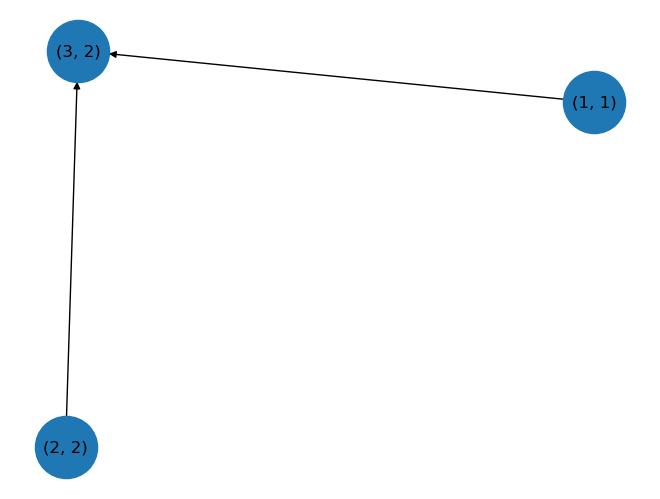

In [1786]:
G = nx.DiGraph()

numNodes = len(components) + len(assemblyNodes) + len(finalNodes)

np.random.seed(0)
maxServiceTimeOutList = 20*np.ones(numNodes)
maxServiceTimeOutList[numNodes-1] = 0

for n in allNodes:
    time = np.random.randint(1, timeUB)
    if n in finalNodes:
        maxTime = 0
    else:
        maxTime = 100
    G.add_node(n, process_time=time, 
               max_service_time_out=maxTime,
               stage_cost=np.random.randint(1, 6))

if multiEchelon is False:
    for n in components:
        for n2 in finalNodes:
            G.add_edge(n, n2)
else:
    for n in assemblyNodes:
        G.add_edge(n, finalNode)
        for component in assembliesStructure[n]:
            G.add_edge(component, n)

maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')
processTimesDict = nx.get_node_attributes(G, 'process_time')
stageCostDict = nx.get_node_attributes(G, 'stage_cost')
maxServiceTimeOut = nx.get_node_attributes(G, 'max_service_time_out')

node_labels = {node: (node, processTimesDict[node]) for node in G.nodes()}
pos = nx.spring_layout(G)
nx.draw(G, pos, labels = node_labels, with_labels=True, node_size=2000)
plt.show()

In [1787]:
safetyFactor = 1.645
sigma = 3
holdingCostRate = 0.2

In [1788]:
def getMaxReplenishmentTime(n : int):
    if n in components:
        return processTimesDict[n]
    else:
        return processTimesDict[n] + max([getMaxReplenishmentTime(i) for i in G.predecessors(n)])
    
def getCumCost(n : int):
    if n in components:
        return stageCostDict[n]
    else:
        return stageCostDict[n] + sum([getCumCost(i) for i in G.predecessors(n)])

maxReplenishmentTime = {n : getMaxReplenishmentTime(n) for n in allNodes}
cumCost = {n : getCumCost(n) for n in allNodes}

df = pd.DataFrame({
    'Node': maxReplenishmentTime.keys(),
    'Process time': processTimesDict.values(),
    'Stage cost': stageCostDict.values(),
    'Cumulative cost': cumCost.values(),
    'Max time': maxServiceTimeOut.values(),
    'maxReplenishmentTime': maxReplenishmentTime.values()
})
df.to_csv('instance.csv')
df

,Node,Process time,Stage cost,Cumulative cost,Max time,maxReplenishmentTime
0,1,1,1,1,100,1
1,2,2,4,4,100,2
2,3,2,2,7,0,4


In [1789]:
processTimesDict

{1: 1, 2: 2, 3: 2}

In [1790]:
def get_sIn_range_for_g_fn(node : int):
    maxVal = maxReplenishmentTime[node] - processTimesDict[node]
    return range(maxVal + 1)

def get_sOut_range_for_g_fn_forIn(node : int, sIn : int):
    maxVal = sIn + processTimesDict[node]
    if node in nonComponentNodes:
        maxVal = min(maxVal, maxServiceTimeOut[node])
    return range(maxVal+1)

def get_sOut_range_for_g_fn_all(node : int):
    vals = set()
    for sIn in get_sIn_range_for_g_fn(node):
        vals = vals.union(set(get_sOut_range_for_g_fn_forIn(node, sIn)))
        #print(sIn, vals)
    return vals

# def get_sOut_rangeForIn(node : int, sIn : int = 0):
#     return range(sIn + processTimesDict[node]+ 1)

def getHoldingCost(node : int, sIn : int, sOut : int):
    return safetyFactor*sigma*holdingCostRate*cumCost[node]*np.sqrt(sIn + processTimesDict[node] - sOut)

def getNodeString(node : int, s : int, isOut : bool):
    if isOut:
        return "{}^{}".format(node, s)
    else:
        return "{}_{}".format(node, s)

In [1791]:
def create_dp_graph(G : nx.DiGraph, multi_commod : bool = False):
    if multi_commod:
        dp_G = nx.MultiDiGraph()
    else:
        dp_G = nx.DiGraph()
    finalNode = finalNodes[0]
    for sIn in get_sIn_range_for_g_fn(finalNode):
        nodeTupleIn = getNodeString(finalNode, sIn, False)
        #if multi_commod:
        dp_G.add_node(nodeTupleIn, nodeType = 'multi-component')
        # else:
        #     dp_G.add_node(nodeTupleIn)
    for sOut in get_sOut_range_for_g_fn_all(finalNode):
        nodeTupleOut = getNodeString(finalNode, sOut, True)
        #if multi_commod:
        dp_G.add_node(nodeTupleOut, nodeType = 'multi-component')
        # else:
        #     dp_G.add_node(nodeTupleOut)
        for sIn in get_sIn_range_for_g_fn(finalNode):
            nodeTupleIn2 = getNodeString(finalNode, sIn, False)
            if multi_commod:
                for component in components:
                    dp_G.add_edge(nodeTupleIn2, nodeTupleOut,
                                commodity = component, 
                                cost = getHoldingCost(finalNode, sIn, sOut))
            else:
                dp_G.add_edge(nodeTupleIn2, nodeTupleOut, 
                           cost = getHoldingCost(finalNode, sIn, sOut))
                
    for n in assembliesStructure:
        for sIn in get_sIn_range_for_g_fn(n):
            nodeTupleIn = getNodeString(n, sIn, False)
            #if multi_commod:
            dp_G.add_node(nodeTupleIn, nodeType = 'multi-component')
            # else:
            #     dp_G.add_node(nodeTupleIn)
        for sOut in get_sOut_range_for_g_fn_all(n):
            print(n, "sIn", sIn, "sOut", sOut)
            nodeTupleOut = getNodeString(n, sOut, True)
            finalNodeTupleIn = getNodeString(finalNode, sOut, False)
            dp_G.add_node(nodeTupleOut, nodeType = 'multi-component')
            if multi_commod:
                if multiEchelon:
                    for component in assembliesStructure[n]:
                        #print("add", nodeTupleOut, finalNodeTupleIn, component)
                        dp_G.add_edge(nodeTupleOut, finalNodeTupleIn, 
                                    commodity = component,
                                        cost = 0)
                else:
                    dp_G.add_edge(nodeTupleOut, finalNodeTupleIn, 
                                    commodity = n,
                                        cost = 0)
            else:
                #dp_G.add_node(nodeTupleOut)
                dp_G.add_edge(nodeTupleOut, finalNodeTupleIn, 
                                cost = 0)
        for sIn in get_sIn_range_for_g_fn(n):
            for sOut in get_sOut_range_for_g_fn_forIn(n, sIn):
                nodeTupleIn = getNodeString(n, sIn, False)
                nodeTupleOut = getNodeString(n, sOut, True)
                if multi_commod:
                    if multiEchelon:
                        for component in assembliesStructure[n]:
                            dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
                                        commodity = component,
                                        cost = getHoldingCost(n, sIn, sOut))
                    else:
                        dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
                                        commodity = n,
                                        cost = getHoldingCost(n, sIn, sOut))
                else:
                    dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
                                cost = getHoldingCost(n, sIn, sOut))
                
        for component in assembliesStructure[n]:
            for sIn in get_sIn_range_for_g_fn(component):
                nodeTupleIn = getNodeString(component, sIn, False)
                #if multi_commod:
                dp_G.add_node(nodeTupleIn, nodeType = 'component')
                # else:
                #     dp_G.add_node(nodeTupleIn)
            for sOut in get_sOut_range_for_g_fn_all(component):
                nodeTupleOut = getNodeString(component, sOut, True)
                assemblyNodeTupleIn = getNodeString(n, sOut, False)
                dp_G.add_node(nodeTupleOut, nodeType = 'component')
                if multi_commod:
                    
                    dp_G.add_edge(nodeTupleOut, assemblyNodeTupleIn, 
                                      commodity = component,
                                    cost = 0)
                else:
                    #dp_G.add_node(nodeTupleOut)
                    dp_G.add_edge(nodeTupleOut, assemblyNodeTupleIn, 
                                    cost = 0)
            for sIn in get_sIn_range_for_g_fn(component):
                for sOut in get_sOut_range_for_g_fn_forIn(component, sIn):
                    nodeTupleOut = getNodeString(component, sOut, True)
                    if multi_commod:
                        dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
                                      commodity = component,
                                    cost = getHoldingCost(component, sIn, sOut))
                    else:
                        dp_G.add_edge(nodeTupleIn, nodeTupleOut, 
                                    cost = getHoldingCost(component, sIn, sOut))
                        
    return dp_G

1 sIn 0 sOut 0
1 sIn 0 sOut 1
2 sIn 0 sOut 0
2 sIn 0 sOut 1
2 sIn 0 sOut 2


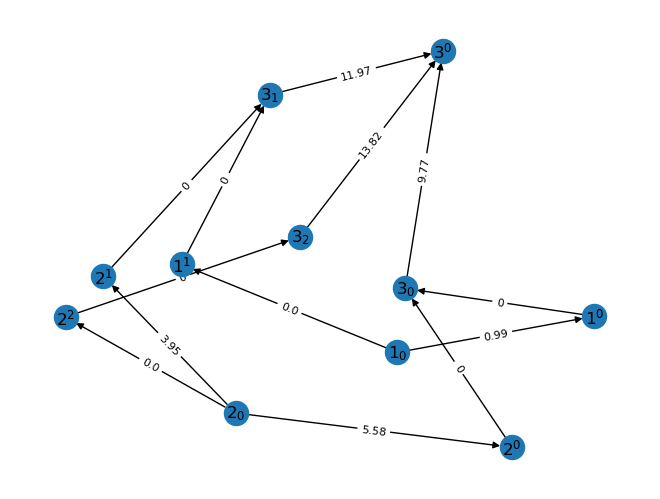

In [1792]:
dp_G = create_dp_graph(G)
node_labels = {node: r'$' +node + '$' for node in dp_G.nodes()}
pos = nx.spring_layout(dp_G)
nx.draw(dp_G, pos, labels = node_labels, with_labels=True)
edge_labels = {(u, v): round(data['cost'],2) 
               for u, v, data in dp_G.edges(data=True)}
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels, 
                             font_size=8)
plt.show()

In [1793]:
def getNetFlowExpr(G, x, node):
    return qsum(x[e] for e in G.out_edges(node)) - qsum(x[e] for e in G.in_edges(node))

finalNodeStr = str(finalNode) + '^0'
startNodes = [str(n) + '_0' for n in components]

nodeTypes = nx.get_node_attributes(dp_G, 'nodeType')
multicommodNodes = [n for n in dp_G.nodes() if nodeTypes[n] == 'multi-component']

def getAllMultiCommodInEdges():
    for n in multicommodNodes:
        for e in dp_G.in_edges(n):
            yield e

def getNetFlowExprRHS(n):
    if n in startNodes:
        return 1
    elif n == finalNodeStr:
        return -len(startNodes)
    else:
        return 0

In [1794]:
def getOptimizedShortestPathModel(vtypeY = GRB.BINARY, log = False):
    m = gp.Model("shortest_path")
    m.Params.LogToConsole = log

    flowEdges = dp_G.edges() - dp_G.in_edges(finalNodeStr)

    x = m.addVars(dp_G.edges(), name="x")
    y = m.addVars(getAllMultiCommodInEdges(), name="y", vtype=vtypeY)
    m._x = x
    m._y = y

    m.setObjective(qsum(x[e]*dp_G.edges[e]['cost'] for e in flowEdges) + 
                qsum(y[e]*dp_G.edges[e]['cost'] for e in y), 
                GRB.MINIMIZE)

    m.addConstrs((x[e] <= numComponents*y[e] for e in y), "UB")
    m.addConstrs((getNetFlowExpr(dp_G, x, n) == getNetFlowExprRHS(n) 
                for n in dp_G.nodes()), "netflow")

    m.optimize()
    m.write('shortest_path.lp')
    return m

m = getOptimizedShortestPathModel(vtypeY = GRB.CONTINUOUS)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))
m = getOptimizedShortestPathModel(log = False)
print("Optimal Cost: $", format(m.ObjVal, ",.2f"))
xVals = [m._x[e].x for e in m._x if m._x[e].x > 0.0]
edgesUsed = list({(e[0], e[1]) for e in m._x if m._x[e].x > 0.0})
costs = [dp_G.edges[e]['cost'] for e in edgesUsed]

df = pd.DataFrame({
    'Edge used': edgesUsed,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
df

Relaxed Cost: $ 12.89
Optimal Cost: $ 19.86


,Edge used,Holding cost
0,"(3_1, 3^0)",$11.97
1,"(2^1, 3_1)",$0.00
2,"(1_0, 1^1)",$0.00
3,"(2_0, 2^1)",$3.95
4,"(1^1, 3_1)",$0.00


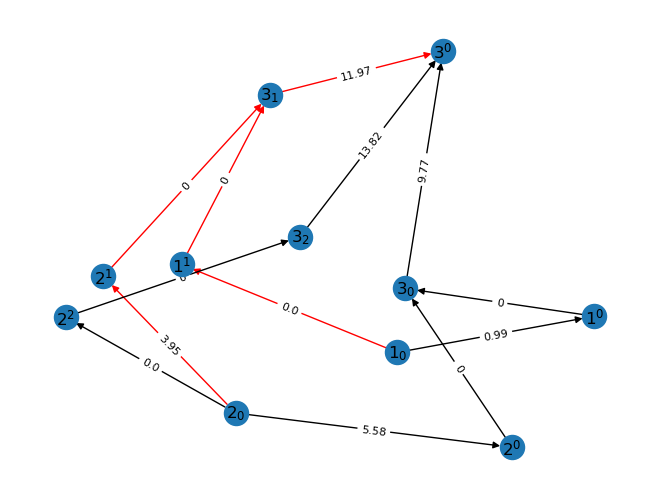

In [1795]:
edgesUsed = [(e[0], e[1]) for e in m._x if m._x[e].x > 0.0]
edge_colors = ['red' if edge in edgesUsed else 'black' 
               for edge in dp_G.edges()]
nx.draw(dp_G, pos, edge_color=edge_colors, 
        labels = node_labels, with_labels=True)
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels, 
                             font_size=8)
plt.show()

In [1796]:
dp_G_multicommod = create_dp_graph(G, multi_commod = True)
nodeTypes = nx.get_node_attributes(dp_G_multicommod, 'nodeType')
commodityEdges = [(e[0], e[1], e[2]['commodity']) for e in dp_G_multicommod.edges(data = True)]

def getCommodityInEdgesForNode(G, node):
    return [(e[0], e[1], e[2]['commodity']) for e in G.in_edges(node, data = True)]

def getAllCommodityInEdges(G):
    edgeList = []
    for n in G.nodes():
        if nodeTypes[n] == 'multi-component':
            edgeList.extend(getCommodityInEdgesForNode(G, n))
    return edgeList

def getInEdgesForNode(G, node):
    return {e for e in G.in_edges(node)}

def getAllInEdges(G):
    edgeList = []
    for n in G.nodes():
        if nodeTypes[n] == 'multi-component':
            edgeList.extend(getInEdgesForNode(G, n))
    return edgeList

def getCommodityOutEdges(G, node):
    return [(e[0], e[1], e[2]['commodity']) for e in G.out_edges(node, data = True)]

1 sIn 0 sOut 0
1 sIn 0 sOut 1
2 sIn 0 sOut 0
2 sIn 0 sOut 1
2 sIn 0 sOut 2


In [1797]:
def handleGurobiStatus(m : gp.Model):
    status = m.status
    if status == GRB.Status.INFEASIBLE:
        print("The model is infeasible. Computing IIS.")
        m.computeIIS()
        m.write('iismodel.ilp')
        sys.exit(0)
    elif status == GRB.Status.UNBOUNDED:
        print("The model is unbounded.")
        sys.exit(0)
    elif status == GRB.Status.OPTIMAL:
        print("The model is optimal.")
    elif status == GRB.Status.INF_OR_UNBD:  
        print("The model status is infeasible or unbounded. Set DualReductions parameter to 0 and reoptimize.")
        sys.exit(0)
    else:
        print("The model status is neither infeasible nor unbounded.")
        sys.exit(0)

In [1798]:
def getNetFlowExpr(G, x, node):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNode(G, node))
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdges(G, node))
    return out_edges_sum - in_edges_sum

def getNetFlowExprWithCommod(G, x, node, commod):
    in_edges_sum = qsum(x[e] for e in getCommodityInEdgesForNode(G, node) if e[2] == commod)
    out_edges_sum = qsum(x[e] for e in getCommodityOutEdges(G, node) if e[2] == commod)
    return out_edges_sum - in_edges_sum

def getNetFlowExprRHS(n):
    if n in startNodes:
        return 1
    elif n == finalNodeStr:
        return -1
    else:
        return 0

def getOptimizedShortestPathModelMulticommodity(vtypeZ = GRB.BINARY, log = False):
    m = gp.Model("shortest_paths")
    m.Params.LogToConsole = log

    inEdges = getAllCommodityInEdges(dp_G_multicommod)
    flowEdges = [item for item in commodityEdges if item not in inEdges]

    edgeCostCommodity = {(e[0], e[1], e[2]['commodity']) : e[2]['cost'] 
                for e in dp_G_multicommod.edges(data = True)}
    
    edgeCost = {(e[0], e[1]) : e[2]['cost']
                for e in dp_G_multicommod.edges(data = True)}

    x = m.addVars(commodityEdges, name="x")
    y = m.addVars(inEdges, name="y")
    z = m.addVars(getAllInEdges(dp_G_multicommod), name="z", vtype=vtypeZ)
    m._x = x
    m._y = y
    m._z = z

    m.setObjective(qsum(edgeCostCommodity[e]*x[e] for e in flowEdges) + 
                qsum(z[e]*edgeCost[e] for e in z), 
                GRB.MINIMIZE)

    m.addConstrs((x[e] <= y[e] for e in y), "UB-y")
    m.addConstrs((y[e] <= z[e[0],e[1]] for c in components for e in y), 
                 "UB-z")
    multiNodes = [n for n in dp_G_multicommod.nodes() if nodeTypes[n] == 'multi-component']
    otherNodes = [n for n in dp_G_multicommod.nodes() if nodeTypes[n] == 'component']
    m.addConstrs((getNetFlowExpr(dp_G_multicommod, x, n) == getNetFlowExprRHS(n) 
                for n in otherNodes), "netflow")
    m.addConstrs((getNetFlowExprWithCommod(dp_G_multicommod, x, n, c) == getNetFlowExprRHS(n) 
                for n in multiNodes for c in components), "netflow-multi")
    m.optimize()
    m.write("multicommodity.lp")
    handleGurobiStatus(m)
    return m

m = getOptimizedShortestPathModelMulticommodity(vtypeZ = GRB.CONTINUOUS, log = False)
print("Relaxed Cost: $", format(m.ObjVal, ",.2f"))
for v in m.getVars():
    if v.x > 0:
        print('%s %g' % (v.varName, v.x))

The model is infeasible. Computing IIS.


SystemExit: 0

/Users/hughdeep/opt/anaconda3/envs/sae-dsc/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
m = getOptimizedShortestPathModelMulticommodity(log = False)
print("Optimal Cost: $", format(m.ObjVal, ",.2f"))

The model is optimal.
Optimal Cost: $ 38.67


In [ ]:
edgesUsed_multicommod = [e for e in m._x if m._x[e].x > 0.0]

In [ ]:
xVals = [m._x[e].x for e in m._x if m._x[e].x > 0.0]
edgesUsed = list({(e[0], e[1]) for e in m._x if m._x[e].x > 0.0})

costs = [dp_G.edges[e]['cost'] for e in edgesUsed]

df = pd.DataFrame({
    'Edge used': edgesUsed,
    'Holding cost': costs
})
df['Holding cost'] = df['Holding cost'].map('${:,.2f}'.format)
print("Cost: $", format(m.ObjVal, ",.2f"))
df

Cost: $ 38.67


,Edge used,Holding cost
0,"(1^0, 5_0)",$0.00
1,"(5^1, 7_1)",$0.00
2,"(2_0, 2^0)",$5.58
3,"(2^0, 5_0)",$0.00
4,"(4_0, 4^0)",$4.19
5,"(5_0, 5^1)",$0.00
6,"(7_1, 7^0)",$25.12
7,"(3_0, 3^0)",$2.79
8,"(3^0, 6_0)",$0.00
9,"(4^0, 6_0)",$0.00


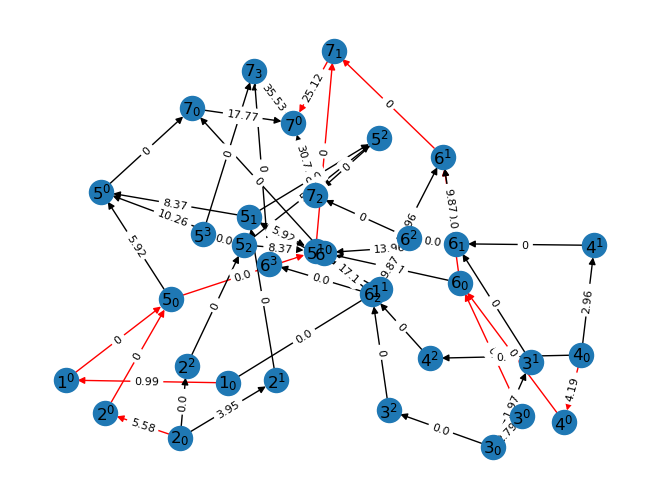

In [ ]:
edgesUsed = [(e[0], e[1]) for e in m._x if m._x[e].x > 0.0]
edge_colors = ['red' if edge in edgesUsed else 'black' 
               for edge in dp_G.edges()]
nx.draw(dp_G, pos, edge_color=edge_colors, 
        labels = node_labels, with_labels=True)
nx.draw_networkx_edge_labels(dp_G, pos, edge_labels=edge_labels, 
                             font_size=8)
plt.show()

## Solution: Inventory Held

In [ ]:
node_labels = {}
for n in G.nodes():
    for sIn in get_sIn_range_for_g_fn(n):
            for sOut in get_sOut_range_for_g_fn_forIn(n, sIn):
                nodeTupleIn = getNodeString(n, sIn, False)
                nodeTupleOut = getNodeString(n, sOut, True)
                if (nodeTupleIn, nodeTupleOut) in edgesUsed:
                    netTime = sIn + processTimesDict[n] - sOut
                    node_labels[n] = '{} ({})'.format(n, netTime)

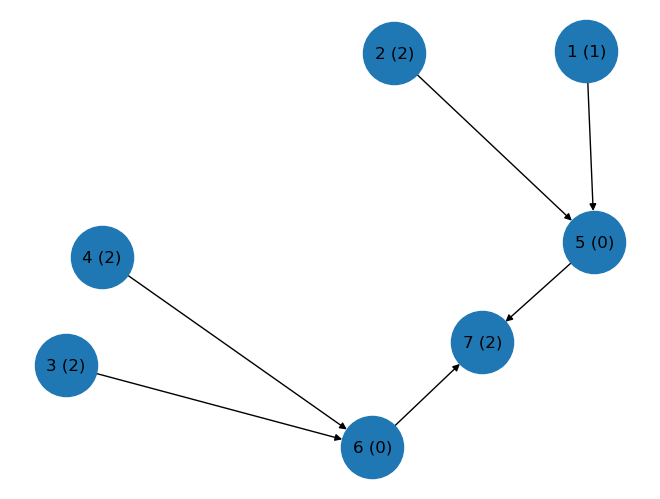

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, labels = node_labels, with_labels=True, node_size=2000)
plt.show()